# Example 02:. Linear Regression with Higher-Level APIs

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch.optim import SGD
from torch.utils.data import (
    TensorDataset, 
    DataLoader,
    random_split,
)
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

## 00. Toy Dataset Generation

In [3]:
num_features = 2
num_examples = 1000

# toy data generation
w_true = torch.tensor([0.5, -2], dtype=torch.float32)
b_true = torch.tensor([1], dtype=torch.float32)

x_total = torch.randn(num_examples, num_features)
t_total = (w_true * x_total).sum(dim=1) + b_true

dataset = TensorDataset(x_total, t_total)
train_set, val_set, test_set = random_split(dataset, lengths=[0.64, 0.16, 0.2])

## 01. Linear Regression Model

In [4]:
# linear transformation + bias addition
model = nn.Linear(in_features=num_features, out_features=1, bias=True)

In [5]:
print(model)

Linear(in_features=2, out_features=1, bias=True)


In [6]:
print(f'{model.weight=}')

model.weight=Parameter containing:
tensor([[ 0.3717, -0.0794]], requires_grad=True)


In [7]:
print(f'{model.weight.shape=}')

model.weight.shape=torch.Size([1, 2])


In [8]:
model.bias

Parameter containing:
tensor([0.2360], requires_grad=True)

In [10]:
### the corresponding functional API
F.linear(torch.randn(16, num_features), model.weight, model.bias)

tensor([[ 0.3716],
        [ 0.5824],
        [-0.1687],
        [-0.0756],
        [ 0.3296],
        [ 0.1079],
        [-0.1049],
        [ 0.2947],
        [ 0.4545],
        [ 0.4416],
        [-0.5658],
        [ 0.4053],
        [ 0.6167],
        [ 0.6477],
        [-0.0336],
        [ 0.3470]], grad_fn=<AddmmBackward0>)

## 02. Optimization Criterion: Mean Squared Error loss (averaged over the batch)

In [13]:
criterion = nn.MSELoss(reduction='mean')

## 03. Optimizer: stochastic gradient descent

In [14]:
optimizer = SGD(params=model.parameters(), lr=0.1)

## 04. Data Loaders for batch training

In [17]:
# DataLoader for training: shuffles data
train_loader = DataLoader(
    dataset=train_set,
    batch_size=64,
    shuffle=True,
    drop_last=True, # drop last incomplete batch if any
)

# DataLoader for validation: no shuffling, keep all data
val_loader = DataLoader(
    dataset=val_set,
    batch_size=64,
    shuffle=False,
    drop_last=False,
)

## 05. Fit

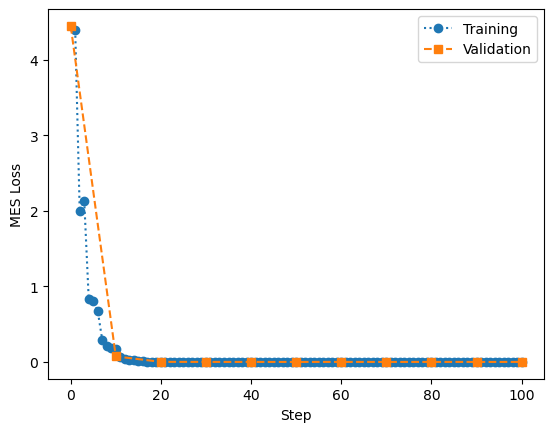

In [18]:
def plot_curve(train_step, train_loss, val_step, val_loss):
    clear_output(wait=True)
    fig, ax = plt.subplots()
    ax.plot(train_step, train_loss, label='Training', ls=':', marker='o')
    ax.plot(val_step, val_loss, label='Validation', ls='--', marker='s')
    ax.set_xlabel(r'Step')
    ax.set_ylabel(r'MES Loss')
    ax.legend()
    display(fig)
    plt.close(fig)

# prepare lists for plotting
train_step_list = []
train_loss_list = []

val_step_list = []
val_loss_list = []

step = 0

max_epochs = 10
for epoch in range(0, max_epochs + 1):

    if epoch > 0:
        # training
        
        for x, t in train_loader:
            y = model(x).squeeze() # forward pass
            loss = criterion(input=y, target=t) # compute loss
            loss.backward() # backpropagate
            optimizer.step() # update weights
            optimizer.zero_grad() # reset gradients

            step += 1
    
            train_step_list.append(step)
            train_loss_list.append(loss.item())
    
    # validation
    val_loss_sum = 0

    with torch.no_grad(): # disable gradient computation for validation
        for x, t in val_loader:
            y = model(x).squeeze()
            loss = F.mse_loss(input=y, target=t, reduction='none')
            val_loss_sum += loss.sum().item()

    val_step_list.append(step)
    val_loss_list.append(val_loss_sum / len(val_set))

    plot_curve(train_step_list, train_loss_list, val_step_list, val_loss_list)